## Face and Facial Keypoint detection

After you've trained a neural network to detect facial keypoints, you can then apply this network to *any* image that includes faces. The neural network expects a Tensor of a certain size as input and, so, to detect any face, you'll first have to do some pre-processing.

1. Detect all the faces in an image using a face detector (we'll be using a Haar Cascade detector in this notebook).
2. Pre-process those face images so that they are grayscale, and transformed to a Tensor of the input size that your net expects. This step will be similar to the `data_transform` you created and applied in Notebook 2, whose job was to rescale, normalize, and turn any image into a Tensor to be accepted as input to your CNN.
3. Use your trained model to detect facial keypoints on the image.

---

In the next python cell we load in required libraries for this section of the project.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

#### Select an image 

Select an image to perform facial keypoint detection on; you can select any image of faces in the `images/` directory.

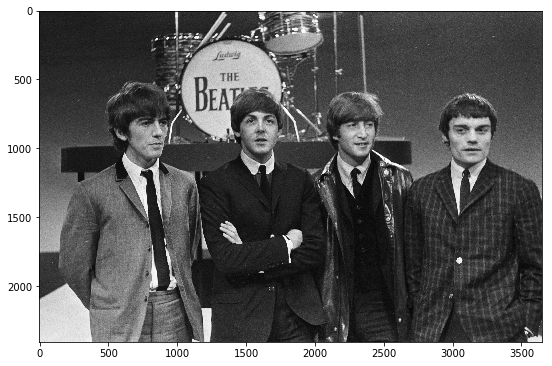

In [2]:
import cv2
# load in color image for face detection
image_1 = cv2.imread('images/obamas.jpg')
image_2 = cv2.imread('images/mona_lisa.jpg')
image_3 = cv2.imread('images/the_beatles.jpg')

# switch red and blue color channels 
# --> by default OpenCV assumes BLUE comes first, not RED as in many images
image_1 = cv2.cvtColor(image_1, cv2.COLOR_BGR2RGB)
image_2 = cv2.cvtColor(image_2, cv2.COLOR_BGR2RGB)
image_3 = cv2.cvtColor(image_3, cv2.COLOR_BGR2RGB)

images = [image_1, image_2, image_3]

# plot the image
fig = plt.figure(figsize=(9,9))
plt.imshow(images[2])

## Detect all faces in an image

Next, you'll use one of OpenCV's pre-trained Haar Cascade classifiers, all of which can be found in the `detector_architectures/` directory, to find any faces in your selected image.

In the code below, we loop over each face in the original image and draw a red square on each face (in a copy of the original image, so as not to modify the original). You can even [add eye detections](https://docs.opencv.org/3.4.1/d7/d8b/tutorial_py_face_detection.html) as an *optional* exercise in using Haar detectors.

An example of face detection on a variety of images is shown below.

<img src='images/haar_cascade_ex.png' width=80% height=80%/>


2 face(s) detected
1 face(s) detected
4 face(s) detected


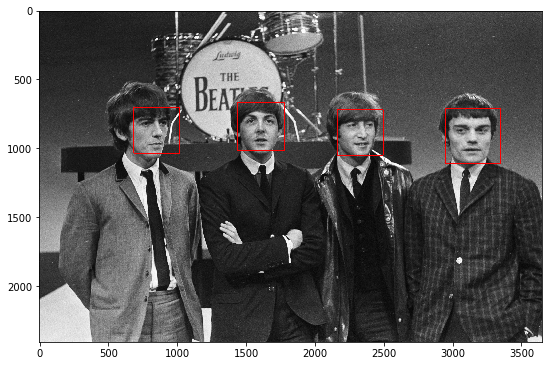

In [3]:
# load in a haar cascade classifier for detecting frontal faces
face_cascade = cv2.CascadeClassifier('detector_architectures/haarcascade_frontalface_default.xml')


# run the detector
# the output here is an array of detections; the corners of each detection box
# if necessary, modify these parameters until you successfully identify every face in a given image

faces_array = []
images_with_detections = []
# make a copy of the original image to plot detections on
for image in images:
    faces_array.append(face_cascade.detectMultiScale(image, 1.3, 5))
    images_with_detections.append(image.copy())

for i, faces in enumerate(faces_array):
    # loop over the detected faces, mark the image where each face is found
    print(f"{len(faces)} face(s) detected")
    for (x,y,w,h) in faces:
        # draw a rectangle around each detected face
        # you may also need to change the width of the rectangle drawn depending on image resolution
        cv2.rectangle(images_with_detections[i], (x,y), (x+w,y+h), (255,0,0), 5) 
        
fig = plt.figure(figsize=(9,9))

plt.imshow(images_with_detections[2])

## Loading in a trained model

Once you have an image to work with (and, again, you can select any image of faces in the `images/` directory), the next step is to pre-process that image and feed it into your CNN facial keypoint detector.

First, load your best model by its filename.

In [4]:
import torch
from models import Net

net = Net()

# net.load_state_dict(torch.load('saved_models/keypoints_model_1.pt'))
net.load_state_dict(torch.load('saved_models/NaimishNet.pt'))

## print out your net and prepare it for testing (uncomment the line below)
net.eval()

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop1): Dropout(p=0.1)
  (bnrm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop2): Dropout(p=0.1)
  (bnrm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop3): Dropout(p=0.1)
  (bnrm3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop4): Dropout(p=0.1)
  (bnrm4): BatchNorm2d(256,

## Keypoint detection

Now, we'll loop over each detected face in an image (again!) only this time, you'll transform those faces in Tensors that your CNN can accept as input images.

### TODO: Transform each detected face into an input Tensor

You'll need to perform the following steps for each detected face:
1. Convert the face from RGB to grayscale
2. Normalize the grayscale image so that its color range falls in [0,1] instead of [0,255]
3. Rescale the detected face to be the expected square size for your CNN (224x224, suggested)
4. Reshape the numpy image into a torch image.

**Hint**: The sizes of faces detected by a Haar detector and the faces your network has been trained on are of different sizes. If you find that your model is generating keypoints that are too small for a given face, try adding some padding to the detected `roi` before giving it as input to your model.

You may find it useful to consult to transformation code in `data_load.py` to help you perform these processing steps.


### TODO: Detect and display the predicted keypoints

After each face has been appropriately converted into an input Tensor for your network to see as input, you can apply your `net` to each face. The ouput should be the predicted the facial keypoints. These keypoints will need to be "un-normalized" for display, and you may find it helpful to write a helper function like `show_keypoints`. You should end up with an image like the following with facial keypoints that closely match the facial features on each individual face:

<img src='images/michelle_detected.png' width=30% height=30%/>




2 face(s) detected


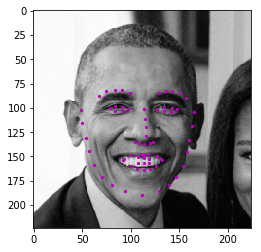

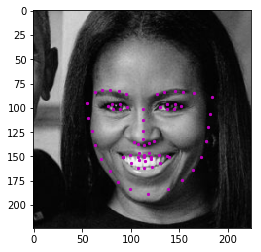

1 face(s) detected


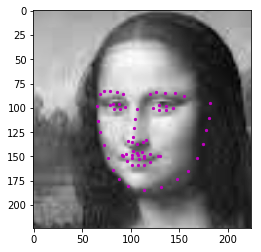

4 face(s) detected


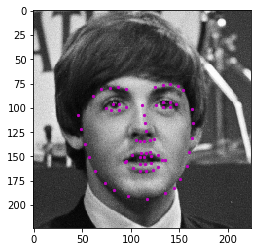

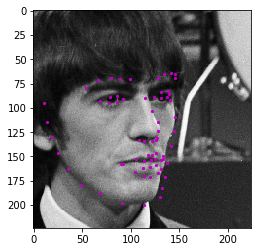

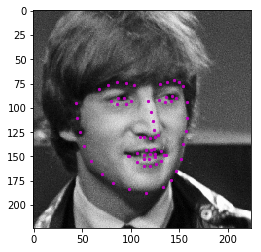

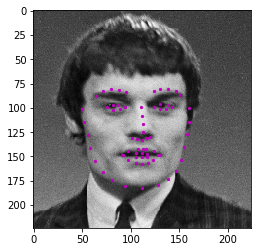

In [5]:
# loop over the detected faces from your haar cascade
def show_keypoints(img_n, pad=0.3): # added padding so that the entire face is on the crop
    faces = faces_array[img_n]
    print(f"{len(faces)} face(s) detected")
    crops = []
    img = images[img_n]
    
    for (x,y,w,h) in faces:

        # Select the region of interest that is the face in the image 
        y_top = int(max(y-pad*h, 0))
        y_bot = int(min(y+h+pad*h, img.shape[0]))
        x_left = int(max(x-pad*w, 0))
        x_right = int(min(x+w+pad*w, img.shape[1]))
        crop = img[y_top:y_bot, x_left:x_right]

        crop = cv2.cvtColor(crop, cv2.COLOR_RGB2GRAY)

        crop = crop/255.0

        crop = cv2.resize(crop, (224, 224))

        if(len(crop.shape) == 2):
                crop_torch = crop.reshape(crop.shape[0], crop.shape[1], 1)
        crop_torch = torch.from_numpy(np.array([crop_torch.transpose((2, 0, 1))])).type(torch.FloatTensor)

        predicted_key_pts = net(crop_torch)
        predicted_key_pts = predicted_key_pts.view(predicted_key_pts.size()[0], 68, -1).detach().numpy()
        predicted_key_pts = np.round(predicted_key_pts*50+100)

        plt.imshow(crop, cmap='gray')
        xs = np.around(predicted_key_pts[:, :, 0])
        ys = np.around(predicted_key_pts[:, :, 1])
        plt.scatter(xs, ys, s=20, marker='.', c='m')
        plt.show()
        
show_keypoints(0)
show_keypoints(1)
show_keypoints(2)